# PV Isotherms from an Implicit Equation of State

For a simple compressible system, the equation of state is
#### Definition. Equation of State (Simple Compressible Systems)
A relation among pressure, volume, and temperature
$$
  f(p,V,T) = 0
$$
We treat an equation of state (EoS) as an implicit constraint

$$
f(p,V,T)=0,
$$

and generate **isotherms** by fixing $T=T_0$ and solving for $p$ as a function of $V$:

$$
f(p(V;T_0),V,T_0)=0.
$$

We will:
1. Define EoS objects via implicit functions $f(p,V,T)$.
2. Generate $p(V)$ isotherms via root-finding (general).
3. Plot $p$–$V$ curves and optionally highlight stability via $(\partial p/\partial V)_T$.


In [1]:
import numpy as np

## Ideal Gas Law
The ideal gas law can be written as
$$
  PV = nR_\text{g}T
$$

to produce isoterms, we could just the value of $T$ and solve for either pressure as a function of V with $T$ being kept fixed, $P(V;T)$.   Or solve for volume as a function of pressure with $T$ being kept fixed, $V(P;T)$.   However, this approach does not generalize for more complicated equations of state, particularly for curves which might be phenological curves.

#### The Bisect Root Method



# Implicit EOS

An equation of state

In [19]:
from typing import Callable
from scipy.optimize import brentq
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import (
    Optional, Tuple,
    Dict, Iterable,
    Protocol, Callable, runtime_checkable, 
    Optional, Tuple
)
import numpy as np
import matplotlib.pyplot as plt

import logging
log = logging.getLogger(__name__)



@runtime_checkable
class EOSLike(Protocol):
    name: str
    f: Callable[[float, float, float], float]
  
    def solve_p(self, 
        V: float, 
        T: float, 
        *, 
        p_bracket: Tuple[float, float] = ...
    ) -> float: ...

class EOSImplicit:
  r"""
  Implicit equation of state for a *simple compressible system*.

  An equation of state is defined as a relation among the thermodynamic state 
  variables pressure (p), volume (V), and temperature (T):

  $$f(p, V, T) = 0$$

  Arguments:
    f(Callable):
    name(str): default:"EOS"
  """
  @staticmethod
  def is_eos(obj) -> bool:
     return isinstance(obj, EOSLike)


  # --- constructor
  def __init__(self, 
      f: Callable, 
      name="EOS"
  ):
    self.f: Callable = f
    self.name: str = name


  def solve_p(self, 
      V: float, 
      T: float, 
      *, 
      p_bracket=(1e-9, 1e9),
      return_nan_on_fail = True,
  ):
    r"""
    Solve $f(p,V,T)=0$ for $p$ using bisection on `p_bracket`.

    Arguments:
      V (float): volume
      T (float): temperature
      p_bracket (float):   
    Returns:
      (float): if pressure is solvable
      np.NaN: if pressure is not solvable
    """
    p_min, p_max = p_bracket
    g = lambda p: self.f(p,V,T)

    try:
      return float(brentq(g, p_min, p_max))
    except ValueError as e:
      log.debug("brentq failed at V=%g, T=%g, bracket=%s", V, T, p_bracket)
      if return_nan_on_fail:
        return np.nan
      else:
        raise
  
    
  @staticmethod
  def generate_isotherm(
      eos: Callable, 
      V_array, 
      T, 
      *, 
      p_bracket=(1e-6, 1e9)):
    assert EOSImplicit.is_eos(eos)
    p_vals = np.empty_like(V_array, dtype=float)
    for i, V in enumerate(V_array):
        p_vals[i] = eos.solve_p(V, T, p_bracket=p_bracket)
    return p_vals

  @staticmethod
  def generate_isotherms(
    eos: Callable, 
    V_array, 
    T_array, 
    *, 
    p_bracket=(1e-6, 1e9)):
    isotherms = {}
    for T in T_array:
      isotherms[T] = EOSImplicit\
        .generate_isotherm(
            eos=eos, 
            V_array=V_array, 
            T=T, 
            p_bracket=p_bracket
        )
    return isotherms 

def plot_isotherms(
    V_array, 
    isotherms, *, 
    title="", 
    xlabel="V (m$^3$/mol)", 
    ylabel="p (Pa)", 
    logx=False, 
    logy=False,
    ax=None):
  if ax is None:
     fig, ax = plt.subplots(1,1)
     fig.set_size_inches(w=5,h=5)
  for T, p in isotherms.items():
    ax.plot(V_array, p, label=f"T = {T:g} K")

  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  if logx:
      ax.xscale("log")
  if logy:
      ax.yscale("log")
  ax.legend()
  ax.grid(True, which="both", linestyle=":")
  if isinstance(fig, plt.Figure):
    plt.tight_layout()
    plt.show()



In [20]:
from physkit.constants import ConstantsSI
def get_EOS_idealgaslaw(n: float = 1.0, R_g: float = ConstantsSI.R_g) -> EOSImplicit:
    def f(p: float, V: float, T: float) -> float:
        return p * V - n * R_g * T
    return EOSImplicit(f, name="Ideal Gas")

eos = get_EOS_idealgaslaw()
print("type:", type(eos))

print("has name:", hasattr(eos, "name"))
if hasattr(eos, "name"):
    print("  name value/type:", eos.name, type(eos.name))

print("has f:", hasattr(eos, "f"))
if hasattr(eos, "f"):
    print("  f callable:", callable(eos.f))

print("has solve_p:", hasattr(eos, "solve_p"))
if hasattr(eos, "solve_p"):
    print("  solve_p callable:", callable(eos.solve_p))


print(EOSImplicit.is_eos(eos))   # True
assert EOSImplicit.is_eos(eos)


type: <class '__main__.EOSImplicit'>
has name: True
  name value/type: Ideal Gas <class 'str'>
has f: True
  f callable: True
has solve_p: True
  solve_p callable: True
True


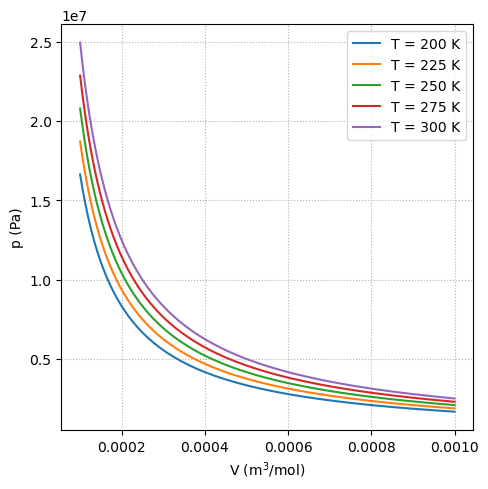

In [24]:
eos = get_EOS_idealgaslaw()
V_array = np.logspace(-4, -3, 500)   # small grid
T_array = [200,225,250,275,300]

isotherms = EOSImplicit.generate_isotherms(eos, V_array, T_array)
isotherms

plot_isotherms(V_array, isotherms=isotherms)

In [ ]:
from physkit.constants import ConstantsSI

R = ConstantsSI.R_g  # J/(mol K)


def get_EOS_vanderwalls(a, b, n=1.0):
    """
    van der Waals in volume form:
        (p + a/V^2)(V - b) = nRT
    """
    def f(p, V, T):
        return (p + a/(V*V))*(V - b) - n*R*T
    return EOSImplicit(f, name="van der Waals")
